In [1]:
import tensorflow as tf

import tensorflow.keras
from tensorflow.keras.layers import Lambda, Input, Dense, Conv2D, Flatten, Conv2DTranspose, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras import backend as K

from load_data import load_train_data, process_daq
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sVAE_utils import sampling, plot_results, build_vae, eval_vae

import numpy as np
import matplotlib.pyplot as plt
import os
from gpu import set_gpu

set_gpu()
# tf.compat.v1.disable_eager_execution()

Num GPUs Available:  1


In [2]:
# Load raw EMG data
feat,params,daq = load_train_data('train_data_raw_AB.mat')
raw = process_daq(daq,params)

# Reshape data for CNN architecture
raw = raw[::2,:,:].transpose(2,1,0)
feat_sq = feat.reshape(feat.shape[0],6,10)

# Index EMG data
sub = 14
grp = 1
ind = (params[:,0] == sub) & (params[:,3] == grp)

In [3]:
# Shuffle and split data
feat_sq_s, label_sq_s = shuffle(feat_sq[ind,:,:],params[ind,-2,np.newaxis])
x_train, x_test, y_train, y_test = train_test_split(feat_sq_s, label_sq_s, test_size=0.3, random_state=0, stratify=label_sq_s)

# Scale data
scaler = MinMaxScaler(feature_range=(-1,1))
x_train = scaler.fit_transform(x_train.reshape(x_train.shape[0],-1)).reshape(x_train.shape)
x_test = scaler.transform(x_test.reshape(x_test.shape[0],-1)).reshape(x_test.shape)
x_train = x_train[...,np.newaxis]
x_test = x_test[...,np.newaxis]
y_train = np.squeeze(y_train-1)
y_test = np.squeeze(y_test-1)

In [5]:
batch_size = 64
latent_dim = 2
epochs = 30

vae, encoder, decoder, clf = build_vae(latent_dim, input_type='feat')

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 6, 10, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 3, 5, 32)     320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 3, 5, 32)     9248        conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 480)          0           conv2d_3[0][0]                   
____________________________________________________________________________________________

In [6]:
models = (encoder, decoder)
data = (x_test, y_test)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [14]:
vae.fit(x_train, {'clf': y_train},epochs=epochs,batch_size=batch_size)
vae.save_weights('vae_feat.h5')

Epoch 1/30
39/39 [==============================] - 0s 5ms/step - loss: 1.8991 - clf_loss: 1.7743
Epoch 2/30
39/39 [==============================] - 0s 5ms/step - loss: 1.4124 - clf_loss: 1.2558
Epoch 3/30
39/39 [==============================] - 0s 5ms/step - loss: 1.2028 - clf_loss: 1.0253
Epoch 4/30
39/39 [==============================] - 0s 5ms/step - loss: 1.0566 - clf_loss: 0.8556
Epoch 5/30
39/39 [==============================] - 0s 4ms/step - loss: 0.9501 - clf_loss: 0.7388
Epoch 6/30
39/39 [==============================] - 0s 4ms/step - loss: 0.8644 - clf_loss: 0.6405
Epoch 7/30
39/39 [==============================] - 0s 5ms/step - loss: 0.8062 - clf_loss: 0.5731
Epoch 8/30
39/39 [==============================] - 0s 4ms/step - loss: 0.7574 - clf_loss: 0.5208
Epoch 9/30
39/39 [==============================] - 0s 4ms/step - loss: 0.7210 - clf_loss: 0.4798
Epoch 10/30
39/39 [==============================] - 0s 4ms/step - loss: 0.6929 - clf_loss: 0.4488
Epoch 11/30
39/39 [

In [7]:
vae.load_weights('vae_feat.h5')

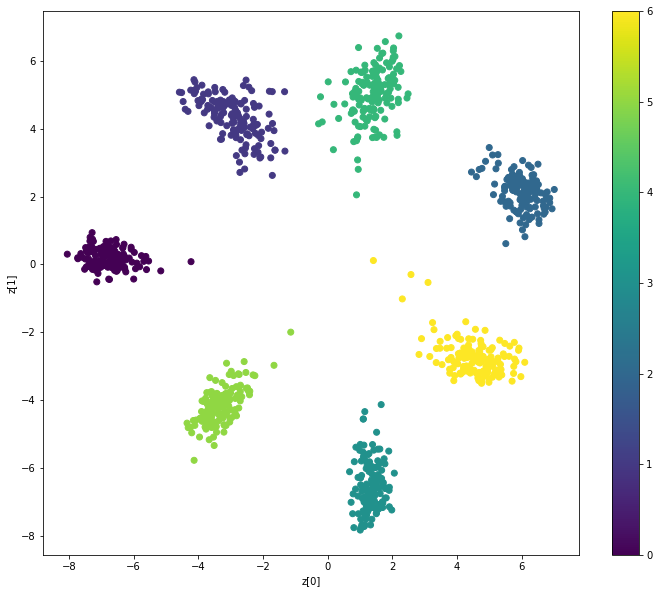

In [8]:
plot_results(models,
                data,
                batch_size=batch_size,
                model_name="vae_mlp")

In [9]:
y_pred, acc = eval_vae(vae, x_train, y_train)

## LDA

In [43]:
# Index EMG data
test_grp = 6
test_ind = (params[:,0] == sub) & (params[:,3] == test_grp)

In [ ]:
# Shuffle and split data
test_feat, test_label = shuffle(raw[test_ind,:,:],params[test_ind,-2,np.newaxis])
x_test = scaler.transform(test_feat.reshape(test_feat.shape[0],-1)).reshape(test_feat.shape)
x_test = x_test[...,np.newaxis]
y_test = np.squeeze(test_label-1)

y_pred = np.argmax(vae.predict(x=x_test)[1], axis=1)
np.sum(y_test == y_pred)/y_pred.shape[0]

In [8]:
from lda import train_lda, predict

# Shuffle and split data
feat_s, label_s = shuffle(feat[ind,:],params[ind,-2,np.newaxis])
x_train_lda = feat_s
y_train_lda = label_s-1

# x_train, _, y_train, _ = train_test_split(x_feats, y_feats, test_size=0.3, random_state=0, stratify=label_s)

w,c = train_lda(x_train_lda,y_train_lda)
out = predict(x_train_lda,w,c)
np.sum(out.reshape(y_train_lda.shape) == y_train_lda)/y_train_lda.shape[0]

0.9928571428571429